In [1]:
import matplotlib.pyplot as plt
import matplotlib
import torch
from torchvision import datasets, transforms
import torchvision
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#p100;7 #t4:1 V100-SXM2-16GB: 10(recently 8-9 aug)
gpu_info = !nvidia-smi -L
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-3dbc5f1a-455e-80a5-4dbc-a5464adb6cde)
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.eConv1 = nn.Conv2d(3,6,4)
        self.eConv2 = nn.Conv2d(6,12,5)
        self.ePool1 = nn.MaxPool2d(2,2)
        self.eConv3 = nn.Conv2d(12,24,5)
        self.ePool2 = nn.MaxPool2d(2,2)
        self.eF1 = nn.Linear(24*4*4,180)
        self.eMu = nn.Linear(180,180)
        self.eSigma = nn.Linear(180,180)

        self.dConvT1 = nn.ConvTranspose2d(180,200,4)
        self.dBatchNorm1 = nn.BatchNorm2d(200)
        self.dConvT2 = nn.ConvTranspose2d(200,120,6,2)
        self.dBatchNorm2 = nn.BatchNorm2d(120)
        self.dConvT3 = nn.ConvTranspose2d(120,60,6,2)
        self.dBatchNorm3 = nn.BatchNorm2d(60)
        self.dConvT4 = nn.ConvTranspose2d(60,3,5,1)

    def encode(self,x):
        # print('input shape', x.shape)  torch.Size([1, 3, 32, 32])
        x = self.eConv1(x)
        # print('conv1 ',x.shape) # conv1  torch.Size([1, 6, 29, 29])
        x = F.relu(x)
        x = self.eConv2(x)
        # print('conv2 ',x.shape) # conv2  torch.Size([1, 12, 25, 25])
        x = F.relu(x)
        x = self.ePool1(x)
        # print('pool1 ',x.shape) # torch.Size([1, 12, 12, 12])
        x = self.eConv3(x)
        # print('conv3 ',x.shape) # conv3  torch.Size([1, 24, 8, 8])
        x = F.relu(x)
        x = self.ePool2(x) #  torch.Size([1, 24, 4, 4])
        # print('pool2 ',x.shape)
        x = x.view(x.size()[0], -1)
        # print('after reshaping ', x.shape) # torch.Size([1, 384])
        x = self.eF1(x)
        # print('after dense ',x.shape) # torch.Size([1, 180])
        mu = self.eMu(x)
        # print('mena vector ',x.shape) # torch.Size([1, 180])
        sigma = self.eSigma(x)
        # print('logvar vector ',x.shape) # torch.Size([1, 180])
        return((mu,sigma))

    # From https://github.com/pytorch/examples/blob/master/vae/main.py
    def reparameterize(self,mu,sigma):
        std = torch.exp(0.5*sigma)
        eps = torch.randn_like(std)
        return (mu + eps*std)

    def decode(self,x):
        # print('decoder input', x.shape) # torch.Size([1, 180])
        x = torch.reshape(x,(x.shape[0],180,1,1))
        # print('decoder reshape', x.shape) # torch.Size([1, 180, 1, 1])
        x = self.dConvT1(x)
        # print('deconv1 ',x.shape) # torch.Size([1, 200, 4, 4])
        x = self.dBatchNorm1(x)
        x = F.relu(x)
        x = self.dConvT2(x) 
        # print('deconv2 ',x.shape) # torch.Size([1, 120, 12, 12])
        x = self.dBatchNorm2(x)
        x = F.relu(x)
        x = self.dConvT3(x)
        # print('deconv3 ',x.shape) #  torch.Size([1, 60, 28, 28])
        x = self.dBatchNorm3(x)
        x = F.relu(x)
        x = self.dConvT4(x)
        # print('dconv4 ',x.shape) # torch.Size([1, 3, 32, 32])
        x = torch.sigmoid(x)
        # print('sigmoid ',x.shape) # torch.Size([1, 3, 32, 32])
        return(x)
        
    def forward(self,x):
        # print('input shpae', x.shape) # input shpae torch.Size([1, 3, 32, 32])
        mu,sigma = self.encode(x)
        z = self.reparameterize(mu,sigma)
        x_gen = self.decode(z)
        return((x_gen,mu,sigma))
        
# From https://github.com/pytorch/examples/blob/master/vae/main.py
# Reconstruction + KL divergence losses summed over all elements and batch


In [6]:
vae = VAE()
vae.to(device)

VAE(
  (eConv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (eConv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (ePool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (eConv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (ePool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (eF1): Linear(in_features=384, out_features=180, bias=True)
  (eMu): Linear(in_features=180, out_features=180, bias=True)
  (eSigma): Linear(in_features=180, out_features=180, bias=True)
  (dConvT1): ConvTranspose2d(180, 200, kernel_size=(4, 4), stride=(1, 1))
  (dBatchNorm1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dConvT2): ConvTranspose2d(200, 120, kernel_size=(6, 6), stride=(2, 2))
  (dBatchNorm2): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dConvT3): ConvTranspose2d(120, 60, kernel_size=(6, 6), stride=(2, 2))
  (dBatchNorm3): BatchNorm2d(60,

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(vae)

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
|   eConv1.weight    |    288     |
|    eConv1.bias     |     6      |
|   eConv2.weight    |    1800    |
|    eConv2.bias     |     12     |
|   eConv3.weight    |    7200    |
|    eConv3.bias     |     24     |
|     eF1.weight     |   69120    |
|      eF1.bias      |    180     |
|     eMu.weight     |   32400    |
|      eMu.bias      |    180     |
|   eSigma.weight    |   32400    |
|    eSigma.bias     |    180     |
|   dConvT1.weight   |   576000   |
|    dConvT1.bias    |    200     |
| dBatchNorm1.weight |    200     |
|  dBatchNorm1.bias  |    200     |
|   dConvT2.weight   |   864000   |
|    dConvT2.bias    |    120     |
| dBatchNorm2.weight |    120     |
|  dBatchNorm2.bias  |    120     |
|   dConvT3.weight   |   259200   |
|    dConvT3.bias    |     60     |
| dBatchNorm3.weight |     60     |
|  dBatchNorm3.bias  |     60     |
|   dConvT4.weight   |    45

1848633

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
%cd  /content/gdrive/MyDrive/deepak/vae

/content/gdrive/MyDrive/deepak/lady_vae


In [ ]:
# 47+16 mins
def imsave(name,img):
	npimg = img.numpy()
	plt.imsave(name,np.transpose(npimg, (1, 2, 0)))

#imshow(torchvision.utils.make_grid(images))

class VAE(nn.Module):
	def __init__(self):
		super(VAE, self).__init__()
		self.eConv1 = nn.Conv2d(3,6,4)
		self.eConv2 = nn.Conv2d(6,12,5)
		self.ePool1 = nn.MaxPool2d(2,2)
		self.eConv3 = nn.Conv2d(12,24,5)
		self.ePool2 = nn.MaxPool2d(2,2)
		self.eF1 = nn.Linear(24*4*4,180)
		self.eMu = nn.Linear(180,180)
		self.eSigma = nn.Linear(180,180)

		self.dConvT1 = nn.ConvTranspose2d(180,200,4)
		self.dBatchNorm1 = nn.BatchNorm2d(200)
		self.dConvT2 = nn.ConvTranspose2d(200,120,6,2)
		self.dBatchNorm2 = nn.BatchNorm2d(120)
		self.dConvT3 = nn.ConvTranspose2d(120,60,6,2)
		self.dBatchNorm3 = nn.BatchNorm2d(60)
		self.dConvT4 = nn.ConvTranspose2d(60,3,5,1)

	def encode(self,x):
		x = self.eConv1(x)
		x = F.relu(x)
		x = self.eConv2(x)
		x = F.relu(x)
		x = self.ePool1(x)
		x = self.eConv3(x)
		x = F.relu(x)
		x = self.ePool2(x)
		x = x.view(x.size()[0], -1)
		x = self.eF1(x)
		mu = self.eMu(x)
		sigma = self.eSigma(x)
		return((mu,sigma))

	# From https://github.com/pytorch/examples/blob/master/vae/main.py
	def reparameterize(self,mu,sigma):
		std = torch.exp(0.5*sigma)
		eps = torch.randn_like(std)
		return (mu + eps*std)

	def decode(self,x):
		x = torch.reshape(x,(x.shape[0],180,1,1))
		x = self.dConvT1(x)
		x = self.dBatchNorm1(x)
		x = F.relu(x)
		x = self.dConvT2(x)
		x = self.dBatchNorm2(x)
		x = F.relu(x)
		x = self.dConvT3(x)
		x = self.dBatchNorm3(x)
		x = F.relu(x)
		x = self.dConvT4(x)
		x = torch.sigmoid(x)
		return(x)
		
	def forward(self,x):
		mu,sigma = self.encode(x)
		z = self.reparameterize(mu,sigma)
		x_gen = self.decode(z)
		return((x_gen,mu,sigma))
		
# From https://github.com/pytorch/examples/blob/master/vae/main.py
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x, x_gen, mu, sigma):
	#print(x.shape)
	#print(x_gen.shape)
	BCE = F.binary_cross_entropy(x_gen, x, reduction='sum')

	# see Appendix B from VAE paper:
	# Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
	# https://arxiv.org/abs/1312.6114
	# 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
	KLD = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

	return BCE + KLD

vae = VAE()
vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(200):

	running_loss = 0.0
	for i, data in enumerate(dataloader, 0):
		# get the inputs; data is a list of [inputs, labels]
		images = data[0].to(device)
		#images = data[0]
		# zero the parameter gradients
		optimizer.zero_grad()

		# forward + backward + optimize
		outputs = vae(images)
		loss = loss_function(images, outputs[0], outputs[1], outputs[2])
		loss.backward()
		optimizer.step()

		# print statistics
		# running_loss += loss.item()
		# if i % 500 == 499:    # print every 500 mini-batches
		# 	print('[%d, %5d] loss: %.3f' %
		# 		  (epoch + 1, i + 1, running_loss / 2000))
		# 	running_loss = 0.0

	PATH = 'vae_checkpoints/'
	torch.save(vae.state_dict(), PATH+str(epoch)+".pt")
	# imsave("actual/" + str(epoch) + ".png", torchvision.utils.make_grid(images.cpu()))
	# imsave("recon/" + str(epoch) + ".png",torchvision.utils.make_grid(outputs[0].detach().cpu()))

print('Finished Training')

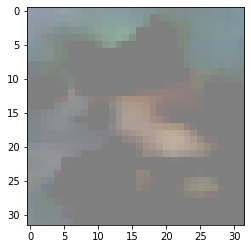

In [ ]:
# unnormalized input images: just to check there are no more dark generated images.
vae = VAE()
vae.load_state_dict(torch.load("vae_checkpoints/199.pt"))
vae.eval()

vectors = torch.randn(1, 180, 1, 1)
images = vae.decode(vectors)
for i in range(vectors.size(0)):
    image = (images[i] * 0.5) + 0.5
    plt.imshow(image.detach().permute(1, 2, 0).numpy())
    plt.show()
# imsave("grid3.png", torchvision.utils.make_grid(images.detach()))

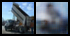

In [ ]:
from random import randint
from torchvision.utils import save_image
from IPython.display import Image
from IPython.core.display import Image, display
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

fixed_x = testset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [ ]:
# Outputs time required to run the current cell
%%capture
!pip install ipython-autotime
%load_ext autotime

# If using scripts, script needs to update automatically after editing
%load_ext autoreload
%autoreload 2
%aimport

time: 24.9 ms (started: 2022-08-12 15:27:43 +00:00)


In [ ]:
!python generate_samples_by_vae.py # 2.17mins

tcmalloc: large alloc 1228800000 bytes == 0x72f0c000 @  0x7fbef23841e7 0x7fbe81c740ce 0x7fbe81ccacf5 0x7fbe81d7386d 0x7fbe81d7417f 0x7fbe81d742d0 0x4bc4ab 0x7fbe81cb5944 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x51566f 0x4bc98a 0x7fbe81cb5944 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x604173 0x5f5506 0x5f8c6c 0x5f9206 0x64faf2 0x64fc4e 0x7fbef1f81c87 0x5b621a
time: 2min 17s (started: 2022-08-12 15:27:52 +00:00)


In [ ]:
xgen = np.load('gen_samples.npz')
x,y,z = torch.from_numpy(xgen['train_data'].transpose((0,3,1,2))),torch.from_numpy(xgen['valid_data'].transpose((0,3,1,2))),torch.from_numpy(xgen['test_data'].transpose((0,3,1,2)))

time: 15.5 s (started: 2022-08-12 15:35:15 +00:00)


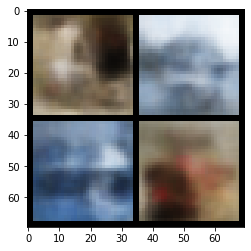

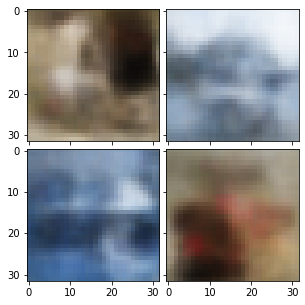

time: 6.77 s (started: 2022-08-12 16:01:04 +00:00)


In [ ]:
# confirm if the images are okay
# for each data, first image confirm with np image

# tensor for train

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

w = x [:4]
grid = torchvision.utils.make_grid(w, nrow=2)
show(grid)

# np for train

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
img_arr = np.load('./xgen/train_data.npz')['train_data'][:4]
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()

